## Imports

The imports required:

In [156]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

import numpy as np
import matplotlib.pyplot as plt

## Data

Reads the CSV files containing the multivariate time series data for valve1. Converts the 'datetime' column to datetime objects and adds a 'timestamp' column representing the time in Unix timestamp format (seconds since epoch). Conversion to unix timestamp is required for training.

In [157]:
multivariate_series = pd.read_csv('https://raw.githubusercontent.com/waico/SKAB/master/data/valve1/13.csv', delimiter=';')

multivariate_series['datetime'] = pd.to_datetime(multivariate_series['datetime'])
multivariate_series['timestamp'] = multivariate_series['datetime'].astype(np.int64) // 10**9

## Model

Model choice was a RandomForestRegressor, Training the model is done, and then the model was used to predict values and compute the difference.

In [158]:
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

residuals = pd.DataFrame(index=multivariate_series.index)
for col in multivariate_series.columns:
    if col != 'datetime' and col != 'timestamp' and col != 'changepoint':
        X_train = multivariate_series[['timestamp']]
        y_train = multivariate_series[col].values
        model.fit(X_train, y_train)
        predicted_values = model.predict(X_train)
        residuals[col] = np.abs(y_train - predicted_values)


## Outlier Subsequences

First, we set a threshold of 3 times the standard deviation of the errors. This choice gave the best results. We then determine the outlier subsequences by marking the start and end indices of each outlier subsequence

In [159]:
threshold = 3 * residuals.std()
    
outliers = (residuals.sum(axis=1) > threshold.sum())
outlier_subsequences = []
start_index = None
for i, is_outlier in enumerate(outliers):
    if is_outlier:
        if start_index is None:
            start_index = i
    elif start_index is not None:
        outlier_subsequences.append((start_index, i - 1))
        start_index = None
if start_index is not None:
    outlier_subsequences.append((start_index, len(outliers) - 1))

## Plot the Results

Plotting the results shows the majority of subseuqnece outliers lie within the section of data that consists in anomalous points.

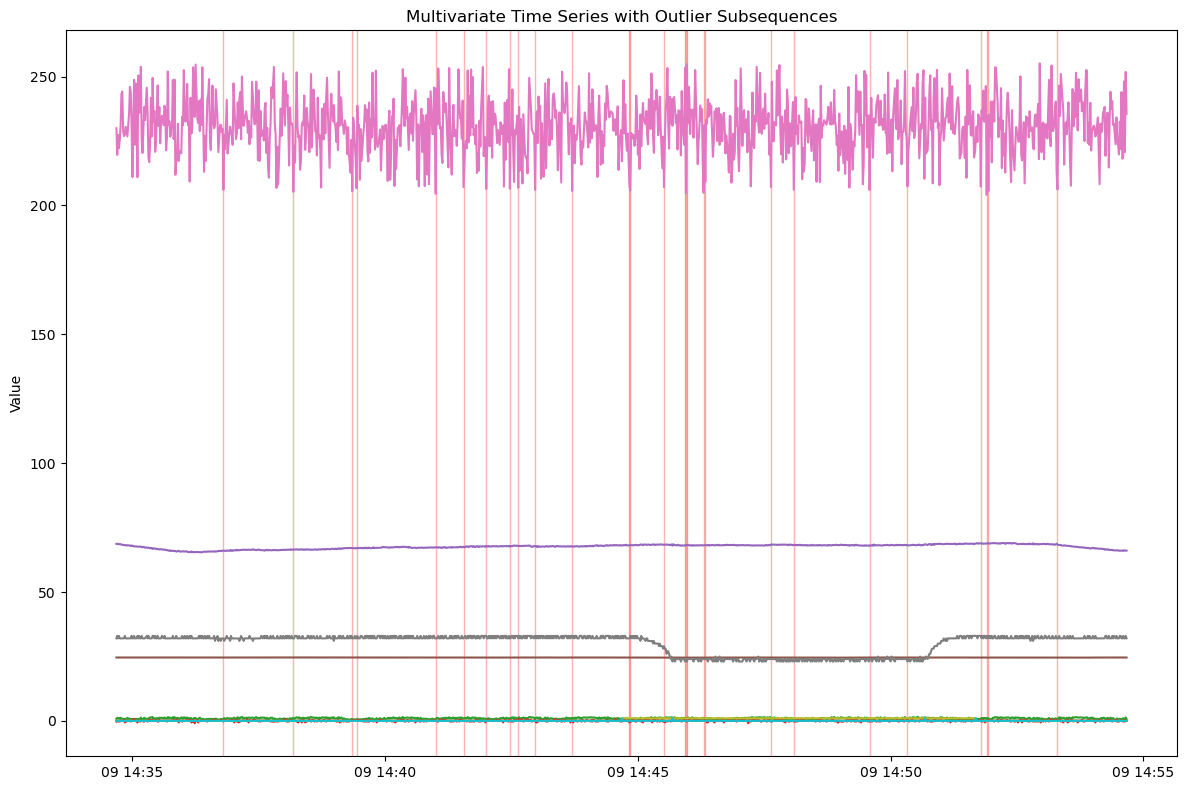

In [160]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True)

for column in multivariate_series.columns[1:-1]:
    ax.plot(multivariate_series['datetime'], multivariate_series[column], label=column)

for outlier in outlier_subsequences:
    start_index, end_index = outlier
    ax.axvspan(multivariate_series.iloc[start_index]['datetime'], 
                   multivariate_series.iloc[end_index]['datetime'], 
                   color='red', alpha=0.3)

ax.set_ylabel('Value')
ax.set_title('Multivariate Time Series with Outlier Subsequences')

plt.tight_layout()
plt.show()